In [31]:
import numpy as np
import scipy
import GPy
import pandas as pd
import matplotlib.pyplot as plt
import csv

from datetime import datetime
%matplotlib inline

In [32]:
# {PatientID -> { delta -> score }}
patient = {}
# Read from CSV and record ALS-FRS score for each patient and with offset
with open('alsfrs.csv') as csvf:
    readCSV = csv.reader(csvf, delimiter=',')
    for i, row in enumerate(readCSV):      
        if i==0: 
            continue
        
        if row[13] and row[12]:
            if row[0] not in patient:
                patient[row[0]] = {float(row[12]): float(row[13])}
            else:
                patient[row[0]][float(row[12])] = float(row[13])

#Create dataframes 
patient_frames = []
for idx, scores in patient.items():
    dates = []
    alsfrs = []
    for date, score in scores.items():
        dates.append(date)
        alsfrs.append(score)
    
    patient = "Patient_" + idx
    data = {"Time offsets": dates, patient: alsfrs}
    
    df = pd.DataFrame(data, columns=['Time offsets', patient])
    patient_frames.append(df)

print(len(patient_frames))

4142


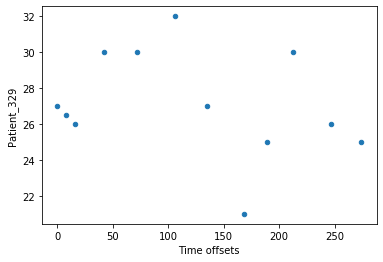

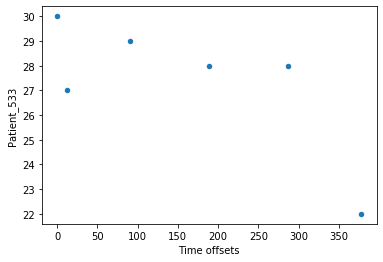

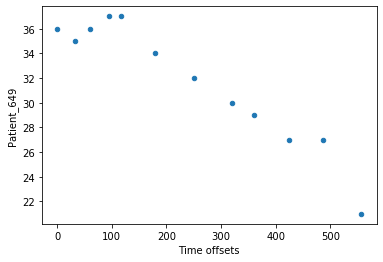

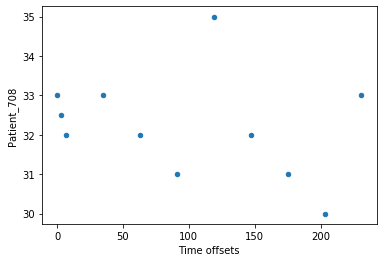

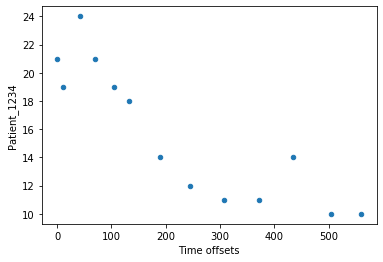

In [33]:
#ALS-FRS graph for each patient over time
for patient in patient_frames[:5]:
    patient.plot(kind="scatter", x=0, y=1)

In [34]:
#Gaussian Process Regression on patients, RBF kernel

# k = GPy.kern.RBF(1)
# k

In [35]:
# Helper function for synthetic data, not needed for PRO-ACT as we have offsets
def datetimeToFloat(dt):
    return (dt - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')

Log likelihood -37.63030304191179
Log likelihood -23.081994621163926
Log likelihood -34.89591633785192
Log likelihood -31.231086351950488
Log likelihood -37.130953073825815
Log likelihood -22.452352020676546
Log likelihood -13.364767481746853
Log likelihood -39.368011429571624
Log likelihood -40.539675128224545
Log likelihood -33.92153144784687
Log likelihood -14.254064669917689
Log likelihood -26.66058242935606
Log likelihood -21.32273858497496
Log likelihood -14.266971819818561
Log likelihood -40.61100469772375


GP_regression.,value,constraints,priors
rbf.variance,356.2965450670866,+ve,
rbf.lengthscale,100.0,+ve fixed,
Gaussian_noise.variance,5.117712678177898,+ve,


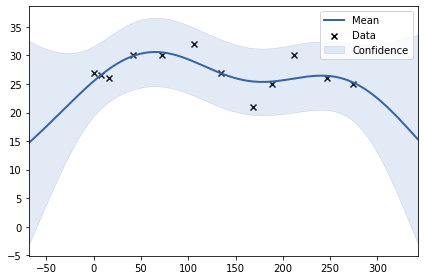

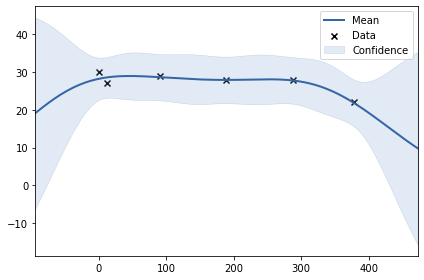

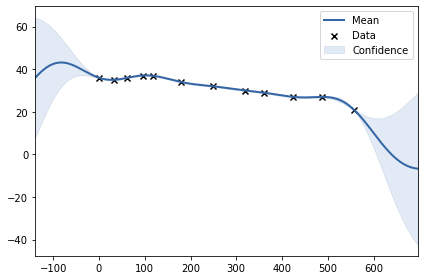

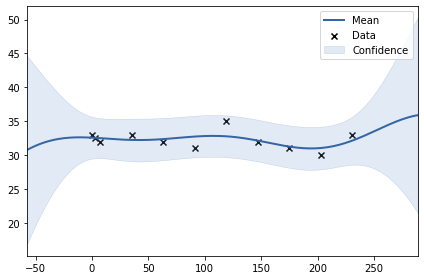

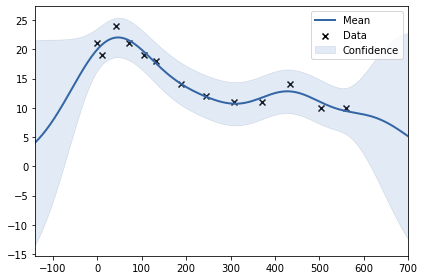

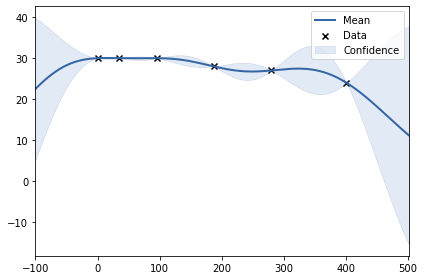

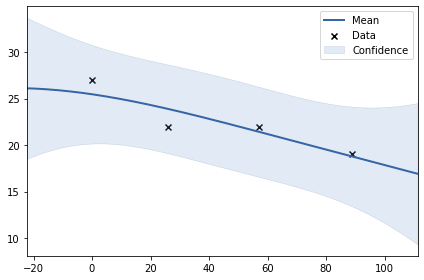

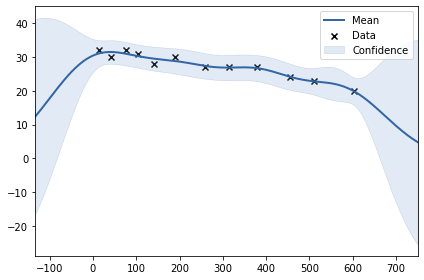

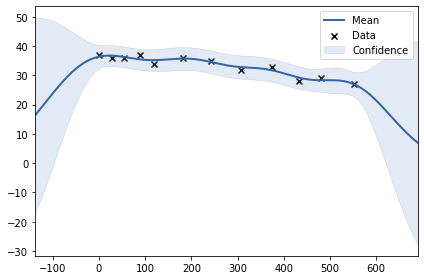

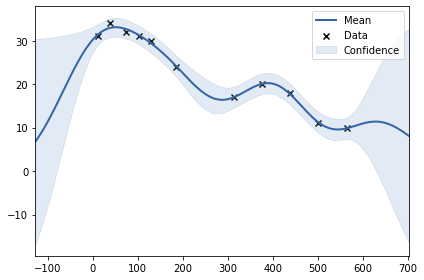

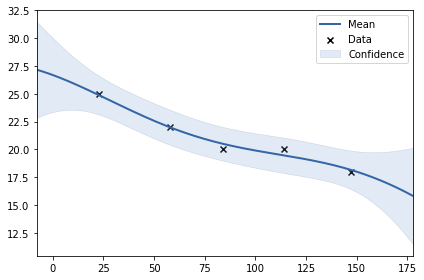

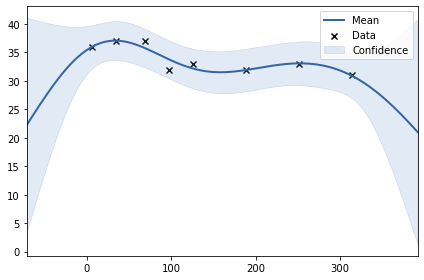

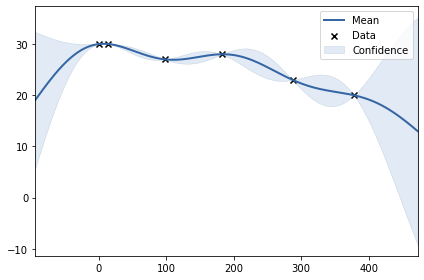

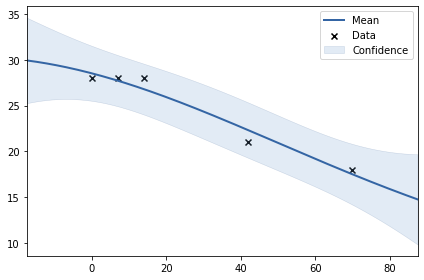

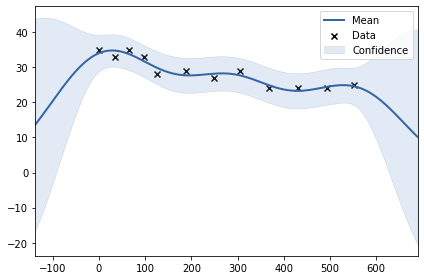

In [45]:
#GPR model for first five patients
GPY_models = []
for patient in patient_frames[:15]:
    X = patient.iloc[:, 0].to_numpy()
    Y = patient.iloc[:, 1].to_numpy()
    
    X_len = len(X)
    X = X.reshape((X_len,1))
    Y = Y.reshape((X_len, 1))
    
    m = GPy.models.GPRegression(X, Y)
    m.kern.lengthscale.fix(100)
    
    m.optimize()
    m.plot()
    print("Log likelihood", m.log_likelihood())
    GPY_models.append(m)

# #Can look at a particular model index if necessary
GPY_models[1]

# X1 = patient_frames[0].iloc[:, 0].to_numpy()
# X2 = patient_frames[1].iloc[:, 0].to_numpy()
# X1 = X1.reshape((len(X1), 1))
# X2 = X2.reshape((len(X2), 1))
# X = np.vstack([X1,X2])
# ind = np.vstack([np.zeros([len(X1),1]),np.ones([len(X2),1])])
# X = np.hstack([X,ind])
# Y1 = patient_frames[0].iloc[:, 1].to_numpy().reshape((len(X1), 1))
# Y2 = patient_frames[1].iloc[:, 1].to_numpy().reshape((len(X2), 1))
# Y = np.vstack([Y1,Y2])

# plt.plot(X[X[:,1]==0,0],Y[X[:,1]==0],'.')
# plt.plot(X[X[:,1]==1,0],Y[X[:,1]==1],'xr')

# m = GPy.models.GPOffsetRegression(X,Y)
# #m.offset.set_prior(GPy.priors.Gaussian())
# m.kern.lengthscale.fix(100)
# m.optimize()
# m

# m.plot(fixed_inputs=[(1,0)],legend=None)
# m

In [48]:
#Clustering algorithm 
count = 0
for model1 in GPY_models[:5]:
    for model2 in GPY_models[:5]:
        if model1 == model2: 
            continue
        # Find the pair with the highest likelihood from merging and merge them into a cluster
        # Delete those two individual models
        # Repeat until all clustered

sample_set = GPY_models[:25]

clusters = []
max_likelihood = sample_set[0].log_likelihood()

c = 25
while c>1: 
    for model1 in sample_set:
        # Merge with each of the clusters with likelihood still over 0.5, record merged liklihood
        for model2 in sample_set:
            # 
            if model1 == model2:
                continue
            
            # Merge the two models, record likelihood, highest likelihood merged models should end up 
            # in a cluster, if likelihood of merged cluster drops below 0.5 then we're done for that cluster 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
